In [12]:
import math

class Value:
    def __init__(self, data, children=(), _op='', label=''):
        self.data = data
        self._prev = set(children)
        self._op = _op
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return (f"Value(data={self.data})")

    ## Create children when we do an operation
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad = out.grad
            other.grad = out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        out._backward = _backward
        return out 

    def tanh(self):
        x = self.data
        t = (math.exp(x*2)-1)/(math.exp(x*2)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = out.grad - 1-t**2

        out._backward = _backward
        return out
    


In [16]:
# lifted from karpathy's jupyter notebook
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



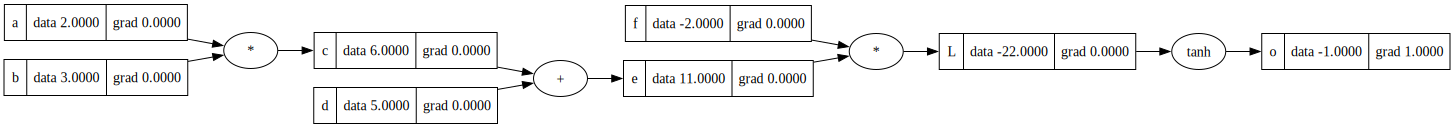

In [ ]:

# Manual labelling and backprop
a = Value(2.0)
a.label = 'a'
b = Value(3.0)
b.label = "b"
c = a * b
c.label = 'c'
d = Value(5.0)
d.label = 'd'
e = c + d
e.label = 'e'
f = Value(-2.0)
f.label = "f"
L = e * f
L.label = 'L'
o = L.tanh()
o.label = 'o'
o.grad = 1.0
o._backward()
draw_dot(o)